<a href="https://colab.research.google.com/github/grace3999/wireless_fiber_photometry/blob/master/FP_VPmult_TTL_230109.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string
from numpy import trapz

from scipy import ndimage
from scipy import signal as ss
from scipy.optimize import curve_fit

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

<ipython-input-2-a3963c680804>:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


### Get paths - separate folders for each day/animal

In [3]:
outer_path = '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort2/VP'

outer_file_list = os.listdir(outer_path)

outer_path_list = []

for name in outer_file_list:
    int_path = outer_path + '/' + name
    outer_path_list.append(int_path)

print(len(outer_path_list))
outer_path_list

6


['/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort2/VP/221216_VP_1_2162_2163',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort2/VP/221217_VP_1_2183_2185',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort2/VP/221216_VP_1_2191_2192',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort2/VP/221216_VP_1_2164_2165',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort2/VP/221216_VP_1_2166_2168',
 '/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort2/VP/221217_VP_1_2202_0000']

### Combine all files into one df

In [4]:
TTL_dir_dataframe = pd.DataFrame()

for outer_path in outer_path_list:

    print(outer_path, '\n')

    #make list of file paths and zip TTL and FP files
    print('Making file list \n')

    TTL_list = []
    FP_list = []

    if outer_path.split('/') == '.DS_Store':
        continue

    inner_file_list = os.listdir(outer_path)
    
    for inner_file in inner_file_list:
        
        if inner_file.split('.')[0].split('_')[-1]=='TTL':
            int_path = outer_path + '/' + inner_file
            TTL_list.append(int_path)
        else:
            int_path = outer_path + '/' + inner_file
            FP_list.append(int_path)
            
    FP_TTL_list = list(zip(sorted(FP_list), sorted(TTL_list)))

    #Combine data from all files and create df
    print('Creating data frame from files \n')

    TTL_dataframe = pd.DataFrame()
    
    for file_pair in FP_TTL_list:

      #get meta data from file path and add to df
      task = file_pair[0].split('/')[-2].split('_')[1]
      session = file_pair[0].split('/')[-2].split('_')[2]
      date = file_pair[0].split('/')[-2].split('_')[0]
      animal1 = file_pair[0].split('/')[-2].split('_')[-2]
      animal2 = file_pair[0].split('/')[-2].split('_')[-1]
      channel = file_pair[0].split('/')[-1].split('_')[-2]
      file_num = file_pair[0].split('/')[-1].split('_')[-1].split('.')[0]

      #get FP and TTL data and convert to list and put in dataframe
      data_int_file = pd.DataFrame(columns=['FP_signal', 'TTL'])
    
      #FP data
      data_FP = pd.melt(pd.read_table(file_pair[0], header=None).T)
      #TTL data
      data_TTL = pd.melt(pd.read_table(file_pair[1], header=None).T)

      data_int_file['FP_signal'] = data_FP['value']
      data_int_file['TTL'] = data_TTL['value']

      data_int_file['date'] = date
      data_int_file['task'] = task
      data_int_file['session'] = session
      data_int_file['channel'] = channel
      data_int_file['file_num'] = file_num
      data_int_file['animal1'] = animal1
      data_int_file['animal2'] = animal2

      if TTL_dataframe.shape[0] == 0:
        TTL_dataframe = data_int_file
      else:
        TTL_dataframe = pd.concat([TTL_dataframe, data_int_file], ignore_index=True)

    #create TTL_prior and then use to mark start of new TTLs for each channel data
    print('Expanding TTLs \n')

    for channel in TTL_dataframe['channel'].unique():

      if channel == 'Ch1':
        print('Skip: ', channel)
        continue
      
      print('Processing channel: ', channel)
      data_int_channel = TTL_dataframe[TTL_dataframe['channel'] == channel]

      if channel == 'Ch2':
        data_int_channel['animal'] = animal1
      if channel == 'Ch3':
        data_int_channel['animal'] = animal2

      data_int_channel['binary'] = [format(x, "08b") for x in data_int_channel['TTL']]

      TTL_prior = list(data_int_channel['binary'][0:-1])
      TTL_prior.insert(0,np.nan)
      data_int_channel['binary_prior'] = TTL_prior

      data_int_channel['binary_start'] = data_int_channel.apply(lambda x : 0 if x['binary'] == x['binary_prior'] else x['binary'], axis=1)

      #reset index to get time column
      data_int_channel = data_int_channel.reset_index().sort_values('index')

      data_int_channel['head_entry'] = [x[7] for x in data_int_channel['binary']]
      data_int_channel['one_pellet'] = [x[6] for x in data_int_channel['binary']]
      data_int_channel['two_pellets'] = [x[5] for x in data_int_channel['binary']]
      data_int_channel['four_pellets'] = [x[4] for x in data_int_channel['binary']]
      data_int_channel['pellet_delivery'] = [x[2] for x in data_int_channel['binary']]
      data_int_channel['session_start'] = [x[1] for x in data_int_channel['binary']]
      data_int_channel['ITI_start'] = [x[0] for x in data_int_channel['binary']]

      #remove start of data 
      try:
        start = data_int_channel[(data_int_channel['binary_start']!=0)&(data_int_channel['session_start']=='0')]['index'].values[0]
        TTL_dataframe_session = data_int_channel[(data_int_channel['index']>=start)]
        TTL_dataframe_session['session_time'] = np.arange(0, TTL_dataframe_session.shape[0]) 

        if TTL_dir_dataframe.shape[0] == 0:
          TTL_dir_dataframe = TTL_dataframe_session
        else:
          TTL_dir_dataframe = pd.concat([TTL_dir_dataframe, TTL_dataframe_session], ignore_index=True)
      except:
        continue

    print('\n')

print(TTL_dir_dataframe.shape)

TTL_dir_dataframe.head()

/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort2/VP/221216_VP_1_2162_2163 

Making file list 

Creating data frame from files 

Expanding TTLs 

Skip:  Ch1
Processing channel:  Ch2
Processing channel:  Ch3


/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort2/VP/221217_VP_1_2183_2185 

Making file list 

Creating data frame from files 

Expanding TTLs 

Skip:  Ch1
Processing channel:  Ch2
Processing channel:  Ch3


/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort2/VP/221216_VP_1_2191_2192 

Making file list 

Creating data frame from files 

Expanding TTLs 

Skip:  Ch1
Processing channel:  Ch2
Processing channel:  Ch3


/content/drive/Shareddrives/Schindler Iterative Translation Lab/data/FP/cohort2/VP/221216_VP_1_2164_2165 

Making file list 

Creating data frame from files 

Expanding TTLs 

Skip:  Ch1
Processing channel:  Ch2
Processing channel:  Ch3


/content/drive/Shareddrives/Schindler Iterat

index  FP_signal  TTL    date task session channel file_num animal1 animal2 animal    binary binary_prior binary_start head_entry one_pellet two_pellets four_pellets pellet_delivery session_start ITI_start  session_time
0  273700  4.715      191  221216  VP   1       Ch2     1        2162    2163    2162   10111111  11111111     10111111     1          1          1           1            1               0             1         0           
1  273701  4.711      191  221216  VP   1       Ch2     1        2162    2163    2162   10111111  10111111     0            1          1          1           1            1               0             1         1           
2  273702  4.713      191  221216  VP   1       Ch2     1        2162    2163    2162   10111111  10111111     0            1          1          1           1            1               0             1         2           
3  273703  4.738      191  221216  VP   1       Ch2     1        2162    2163    2162   10111111  10111111     0            1          1          1           1            1               0             1         3           
4  273704  4.716      191  221216  VP   1       Ch2     1        2162    2163    2162   10111111  10111111     0            1          1          1           1            1               0             1         4

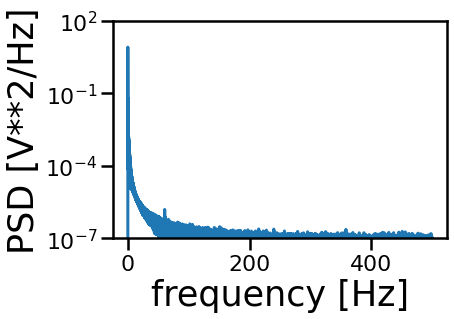

In [11]:
f, Pxx_den = ss.periodogram(data_int_channel['FP_signal'], 1000)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

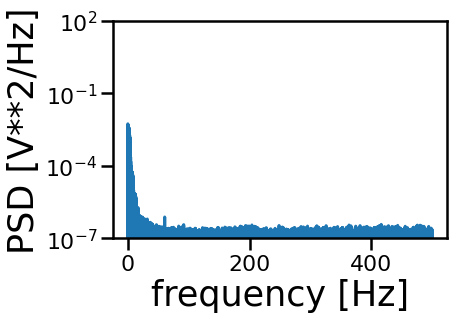

In [12]:
f, Pxx_den = ss.periodogram(TTL_dir_dataframe['FP_signal'], 1000)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

### Peri event

#### functions

In [5]:
#guppy functions
def curveFitFn(x,a,b,c):
    return a+(b*np.exp(-(1/c)*x))

def deltaFF(signal, control):
    res = np.subtract(signal, control)
    normData = np.divide(res, control)
    normData = normData*100
    return normData

def controlFit(control, signal):
	  p = np.polyfit(control, signal, 1)
	  arr = (p[0]*control)+p[1]
	  return arr

In [10]:
def peri_event_guppy(data, time, total_time, baseline_time):
    
    #time = time when event happens
    #total_time = total length of peri event
    #baseline_time = baseline duration (assumed that this should be taken from immediately prior to the event)
    
    start_time = time - baseline_time
    end_time = start_time + total_time
    
    #get peri event signal
    data_int = data[(data['session_time'] >= start_time) & (data['session_time'] < (end_time))]
    data_int['event_time'] = np.arange(0, data_int.shape[0]) / 1000

    #apply 5hz lowpass filter 
    b, a = ss.butter(4, 5, 'low', fs=1000) 
    output = ss.filtfilt(b, a, data_int['FP_signal'])
    data_int['FP_signal_5hz'] = output

    #median filter to remove disconnects
    result = ndimage.median_filter(data_int['FP_signal'].values, size=5)
    data_int['FP_signal_medfilt'] = result

    #create control channel
    timestamps = data_int['session_time'].values
    signal = data_int['FP_signal_5hz'].values
    window = 15

    filtered_signal = ss.savgol_filter(signal, window_length=window, polyorder=3)
    data_int['FP_signal_savfilt'] = filtered_signal
    p0 = [5,50,60]
    popt, pcov = curve_fit(curveFitFn, timestamps, filtered_signal, p0)
    control = curveFitFn(timestamps,*popt)

    #guppy execute_controlFit_dff
    b = np.divide(np.ones((window,)), window)
    a = 1
    signal_smooth = ss.filtfilt(b, a, signal)
    control_fit = controlFit(control, signal_smooth)
    norm_data = deltaFF(signal_smooth, control_fit)

    data_int['control_fit'] = control_fit
    data_int['norm_data'] = norm_data

    #guppy zscore
    numerator = np.subtract(norm_data, np.nanmean(norm_data))
    zscore = np.divide(numerator, np.nanstd(norm_data))
    data_int['deltFF_sig_z'] = zscore

    baseline = np.nanmean(data_int[(data_int['session_time'] >= start_time) & (data_int['session_time'] < (time))]['deltFF_sig_z'].values)
    baselineSub = np.subtract(zscore, baseline)
    data_int['deltFF_baseline_z'] = baselineSub

    numerator = np.subtract(output, np.nanmean(output))
    zscore = np.divide(numerator, np.nanstd(output))
    data_int['sig_z'] = zscore

    baseline = np.nanmean(data_int[(data_int['session_time'] >= start_time) & (data_int['session_time'] < (time))]['sig_z'].values)
    baselineSub = np.subtract(zscore, baseline)
    data_int['baseline_z'] = baselineSub

    return data_int

In [8]:
def robustz_df(TTL_dataframe_session, event_col):
    
    times_int = TTL_dataframe_session[(TTL_dataframe_session['binary_start']!=0)&(TTL_dataframe_session[event_col]=='0')]['session_time'].values
    #print(times_int)
    
    i=0
    prev_time=6000
    data_final_int = pd.DataFrame()
    for time in times_int:
      print(time)
      if time - prev_time < 5000:
        print('skip')
        continue
      if time - prev_time > 5000:
        data_int_peri = peri_event_guppy(TTL_dataframe_session, time, 15000, 5000)
        data_int_peri['trial'] = i
        prev_time = time
        i+=1
        if data_final_int.shape[0] == 0:
          data_final_int = data_int_peri
        else:
          data_final_int = pd.concat([data_final_int, data_int_peri], axis=0)

    return data_final_int

#### Process

In [9]:
PE_df = pd.DataFrame()

for animal in TTL_dir_dataframe['animal'].unique():
  print('Processing animal: ', animal)
  if animal == '0000':
    print('Skip \n')
    continue
  if animal == 0:
    print('Skip \n')
    continue

  animal_df = TTL_dir_dataframe[TTL_dir_dataframe['animal']==animal]

  for session in animal_df['session'].unique():
    print('Processing session: ', session) 
    animal_session_df = animal_df[animal_df['session']==session].sort_values('session_time')

    #Get event times for session
    print('Processing perievent...')
    event_list = ['one_pellet', 'two_pellets', 'four_pellets']
    prev_event_time = 0

    for event in event_list:
      d1 = robustz_df(animal_session_df, event)

      d1['date'] = animal_session_df['date'].unique()[0]
      d1['task'] = animal_session_df['task'].unique()[0]
      d1['session'] = animal_session_df['session'].unique()[0]
      d1['animal'] = animal_session_df['animal'].unique()[0]
      d1['event'] = event

      if PE_df.shape[0] == 0:
          PE_df = d1
      else:
          PE_df = pd.concat([PE_df, d1], axis=0)


PE_df.head()

Processing animal:  2162
Processing session:  1
Processing perievent...
181200
176200 191200
(15000, 22)
(15000, 32)
362600
357600 372600
(15000, 22)
(15000, 32)
544000
539000 554000
(15000, 22)
(15000, 32)
150600
145600 160600
(15000, 22)
(15000, 32)
332000
327000 342000
(15000, 22)
(15000, 32)
422100
417100 432100
(15000, 22)
(15000, 32)
89000
84000 99000
(15000, 22)
(15000, 32)
270300
265300 280300
(15000, 22)
(15000, 32)
512000
507000 522000
(15000, 22)
(15000, 32)
Processing animal:  2163
Processing session:  1
Processing perievent...
29600
24600 39600
(15000, 22)
(15000, 32)
362600
357600 372600
(15000, 22)
(15000, 32)
451800
446800 461800
(15000, 22)
(15000, 32)
89200
84200 99200
(15000, 22)
(15000, 32)
211000
206000 221000
(15000, 22)
(15000, 32)
481700
476700 491700
(15000, 22)
(15000, 32)
179100
174100 189100
(15000, 22)
(15000, 32)
271200
266200 281200
(15000, 22)
(15000, 32)
541900
536900 551900
(15000, 22)
(15000, 32)
Processing animal:  2183
Processing session:  1
Process

index  FP_signal  TTL    date task session channel file_num animal1 animal2 animal    binary binary_prior binary_start head_entry one_pellet two_pellets four_pellets pellet_delivery session_start ITI_start  session_time  event_time  FP_signal_5hz  FP_signal_medfilt  FP_signal_savfilt  control_fit  norm_data  deltFF_sig_z  deltFF_baseline_z     sig_z  baseline_z  trial       event
176200  809900  4.715      255  221216  VP   1       Ch2     4        2162    2163    2162   11111111  11111111     0            1          1          1           1            1               1             1         176200        0.000       4.715288       4.715              4.715288           4.663992     1.099836   0.112609     -0.002508           0.112326 -0.002502    0      one_pellet
176201  809901  4.717      255  221216  VP   1       Ch2     4        2162    2163    2162   11111111  11111111     0            1          1          1           1            1               1             1         176201        0.001       4.715296       4.715              4.715296           4.663992     1.100018   0.112627     -0.002490           0.112344 -0.002484    0      one_pellet
176202  809902  4.712      255  221216  VP   1       Ch2     4        2162    2163    2162   11111111  11111111     0            1          1          1           1            1               1             1         176202        0.002       4.715305       4.712              4.715305           4.663992     1.100200   0.112646     -0.002471           0.112363 -0.002465    0      one_pellet
176203  809903  4.709      255  221216  VP   1       Ch2     4        2162    2163    2162   11111111  11111111     0            1          1          1           1            1               1             1         176203        0.003       4.715313       4.712              4.715313           4.663992     1.100381   0.112665     -0.002453           0.112381 -0.002447    0      one_pellet
176204  809904  4.712      255  221216  VP   1       Ch2     4        2162    2163    2162   11111111  11111111     0            1          1          1           1            1               1             1         176204        0.004       4.715322       4.712              4.715322           4.663992     1.100563   0.112683     -0.002434           0.112400 -0.002428    0      one_pellet

In [11]:
PE_df.groupby(['animal', 'event'])['trial'].value_counts()

animal  event         trial
2162    four_pellets  0        15000
                      1        15000
                      2        15000
        one_pellet    0        15000
                      1        15000
                      2        15000
        two_pellets   0        15000
                      1        15000
                      2        15000
2163    four_pellets  0        15000
                      1        15000
                      2        15000
        one_pellet    0        15000
                      1        15000
                      2        15000
        two_pellets   0        15000
                      1        15000
                      2        15000
2164    four_pellets  0        15000
                      1        15000
                      2        15000
        one_pellet    0        15000
                      1        15000
                      2        15000
        two_pellets   0        15000
                      1        15000
          

In [12]:
PE_df.to_csv('VP_cohort2_230110.csv')

### Viz

In [13]:
PE_df.head()

index  FP_signal  TTL    date task session channel file_num animal1 animal2 animal    binary binary_prior binary_start head_entry one_pellet two_pellets four_pellets pellet_delivery session_start ITI_start  session_time  event_time  FP_signal_5hz  FP_signal_medfilt  FP_signal_savfilt  control_fit  norm_data  deltFF_sig_z  deltFF_baseline_z     sig_z  baseline_z  trial       event
176200  809900  4.715      255  221216  VP   1       Ch2     4        2162    2163    2162   11111111  11111111     0            1          1          1           1            1               1             1         176200        0.000       4.715288       4.715              4.715288           4.663992     1.099836   0.112609     -0.002508           0.112326 -0.002502    0      one_pellet
176201  809901  4.717      255  221216  VP   1       Ch2     4        2162    2163    2162   11111111  11111111     0            1          1          1           1            1               1             1         176201        0.001       4.715296       4.715              4.715296           4.663992     1.100018   0.112627     -0.002490           0.112344 -0.002484    0      one_pellet
176202  809902  4.712      255  221216  VP   1       Ch2     4        2162    2163    2162   11111111  11111111     0            1          1          1           1            1               1             1         176202        0.002       4.715305       4.712              4.715305           4.663992     1.100200   0.112646     -0.002471           0.112363 -0.002465    0      one_pellet
176203  809903  4.709      255  221216  VP   1       Ch2     4        2162    2163    2162   11111111  11111111     0            1          1          1           1            1               1             1         176203        0.003       4.715313       4.712              4.715313           4.663992     1.100381   0.112665     -0.002453           0.112381 -0.002447    0      one_pellet
176204  809904  4.712      255  221216  VP   1       Ch2     4        2162    2163    2162   11111111  11111111     0            1          1          1           1            1               1             1         176204        0.004       4.715322       4.712              4.715322           4.663992     1.100563   0.112683     -0.002434           0.112400 -0.002428    0      one_pellet

2162
(45000, 34)


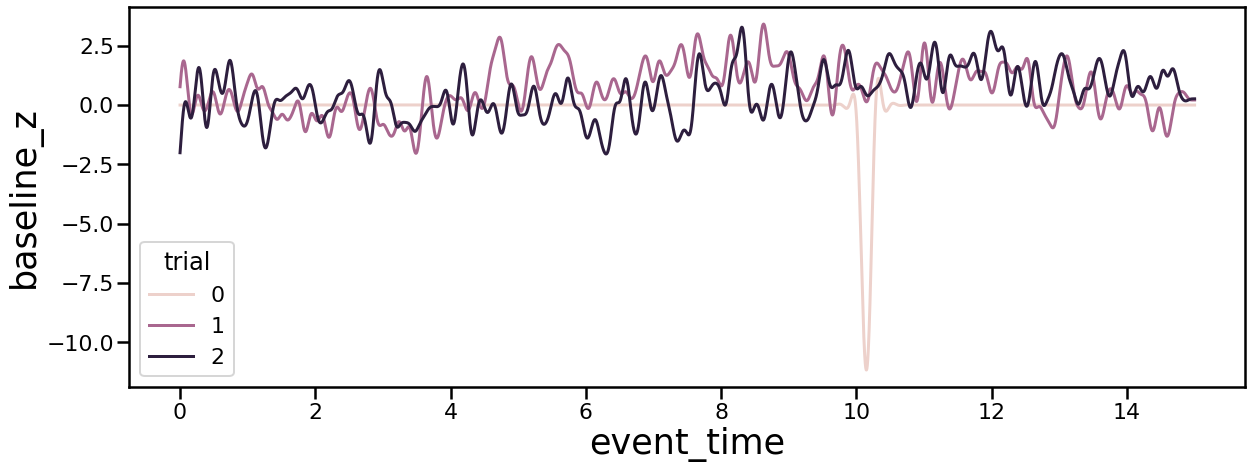

(45000, 34)


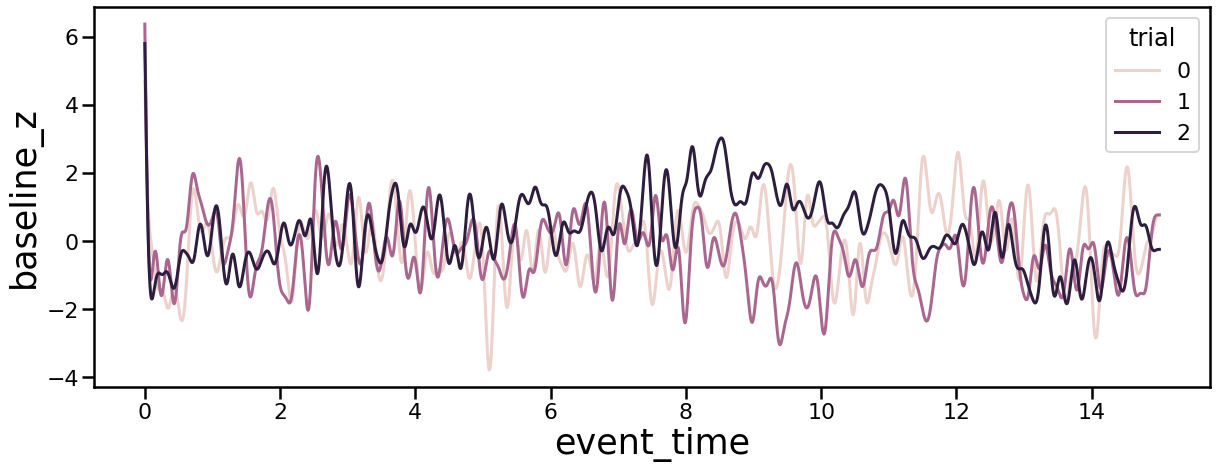

(45000, 34)


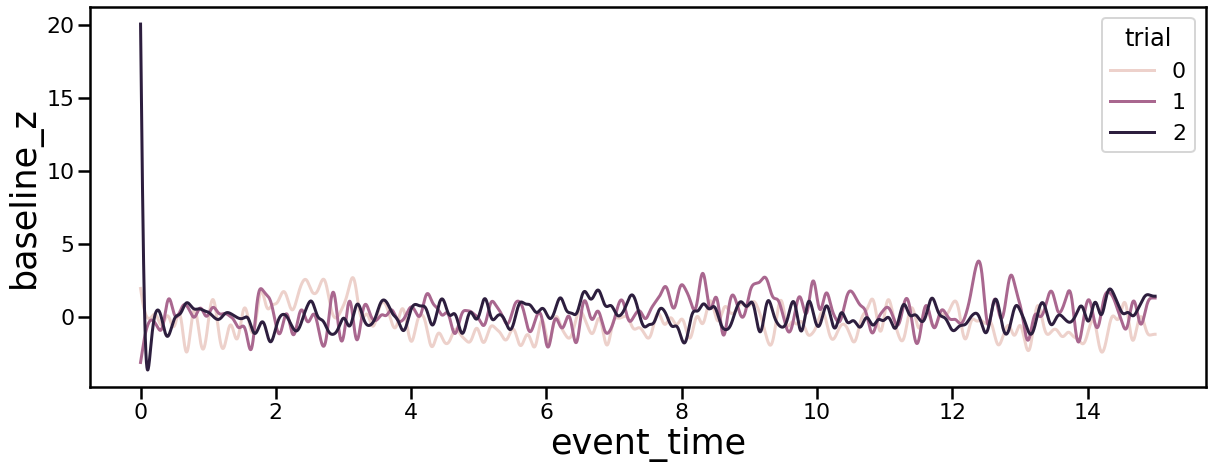

2163
(45000, 34)


(45000, 34)


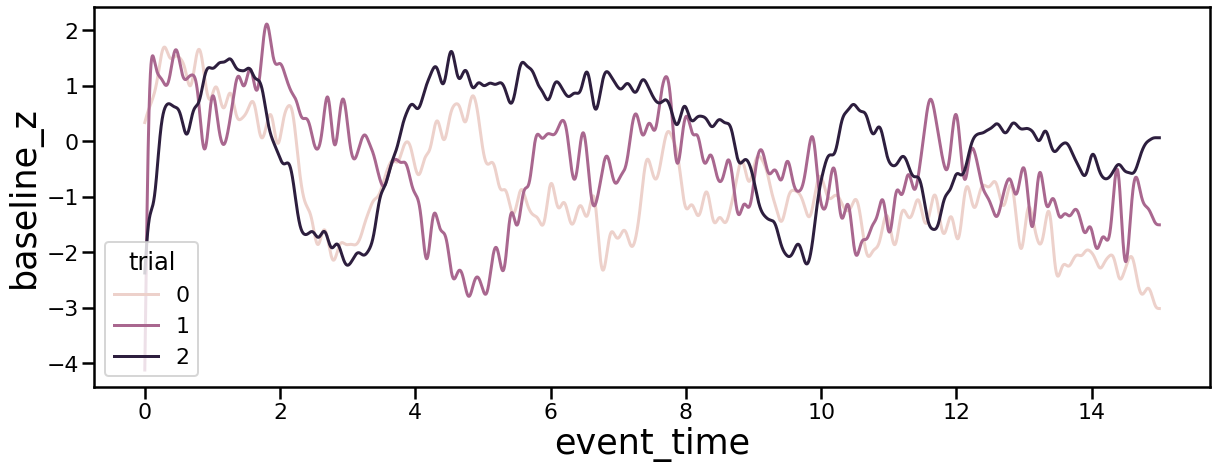

(45000, 34)


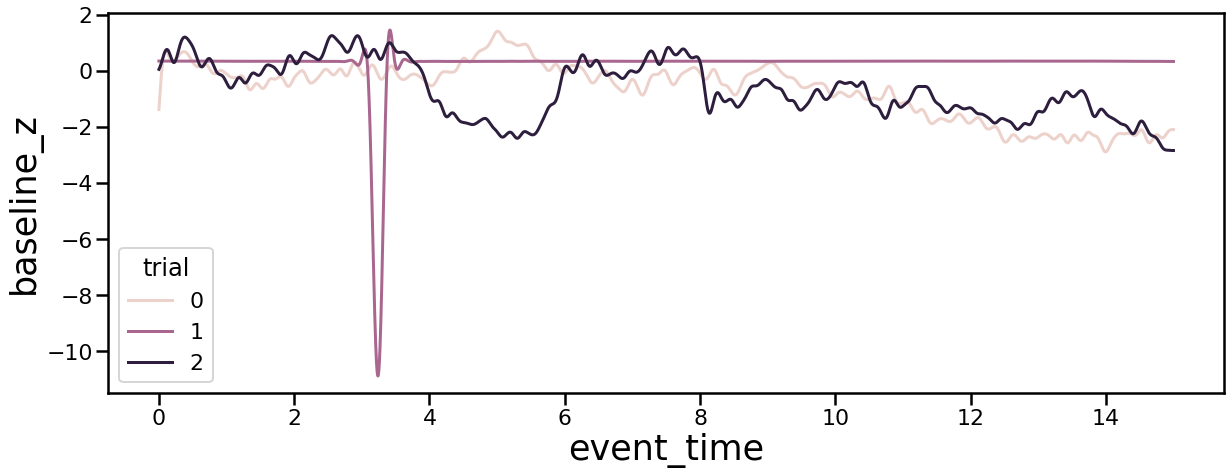

2183
(45000, 34)


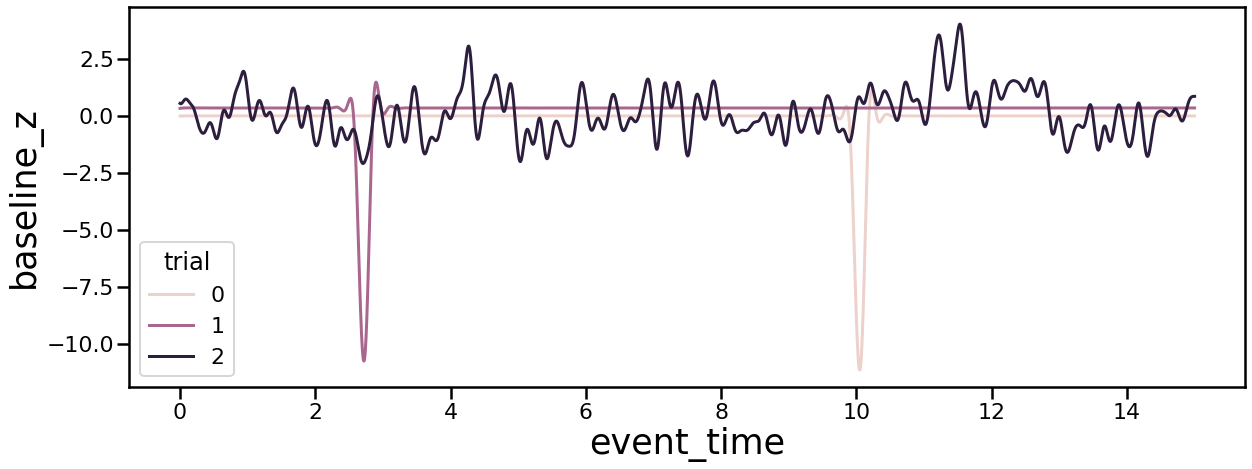

(45000, 34)


(45000, 34)


2185
(45000, 34)


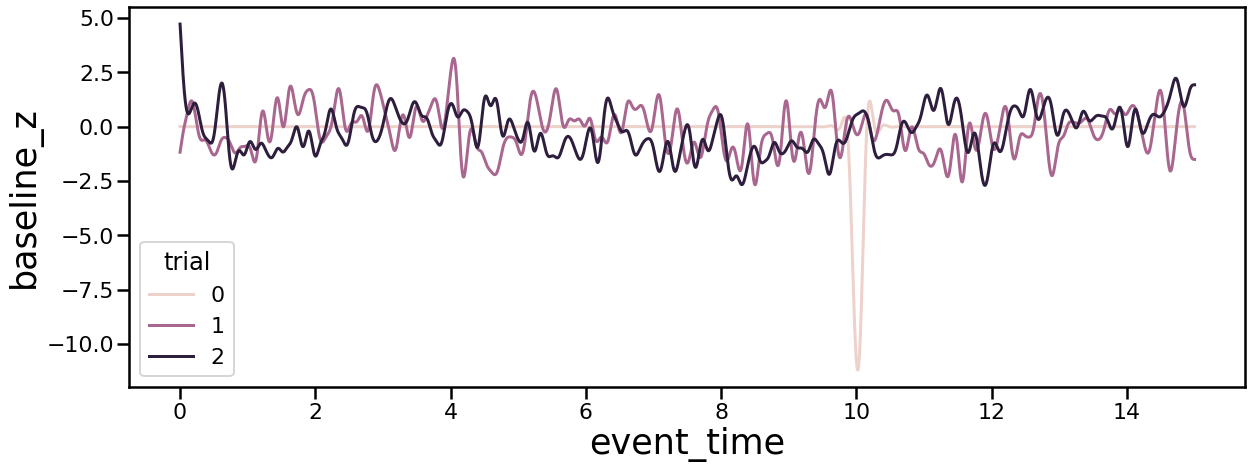

(45000, 34)


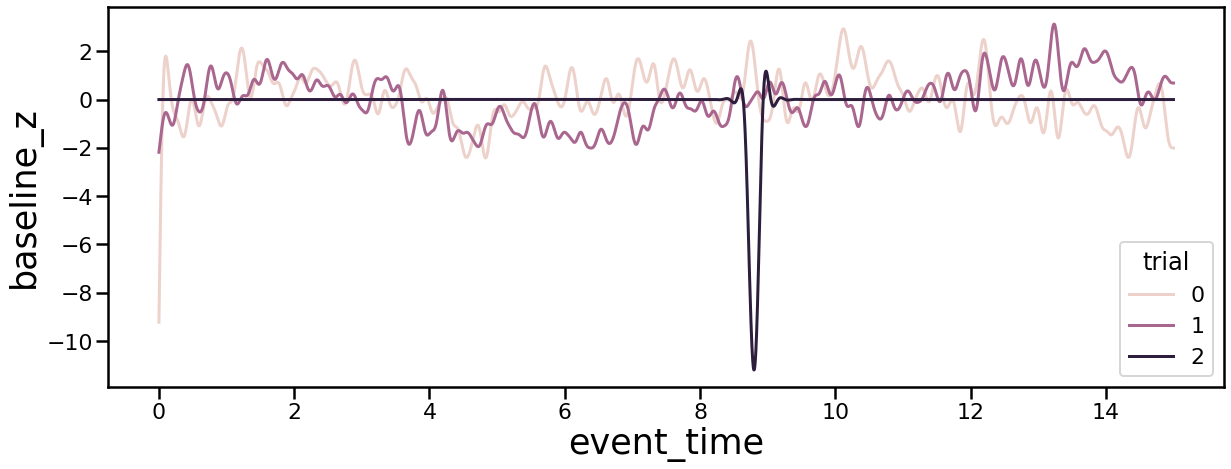

(45000, 34)


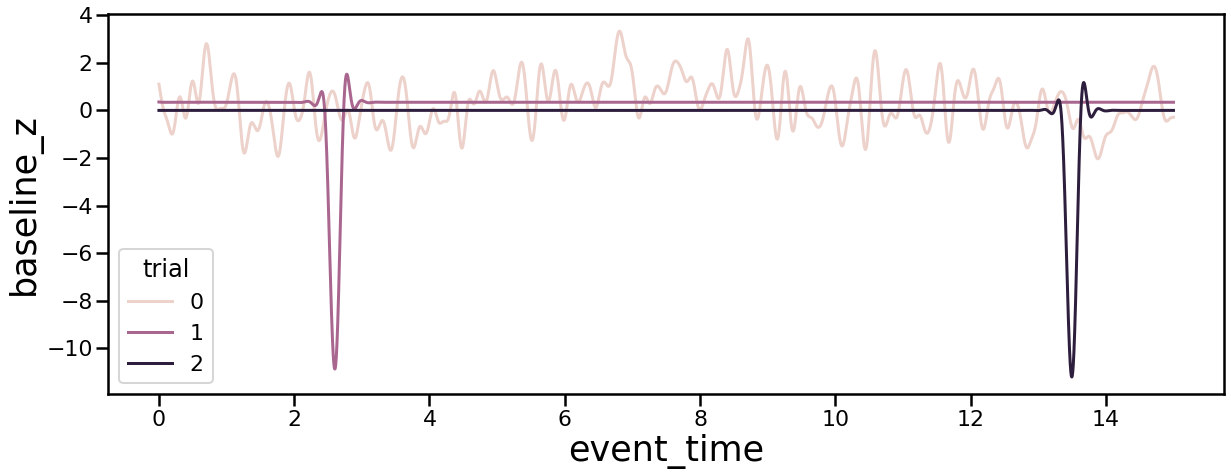

2191
(45000, 34)


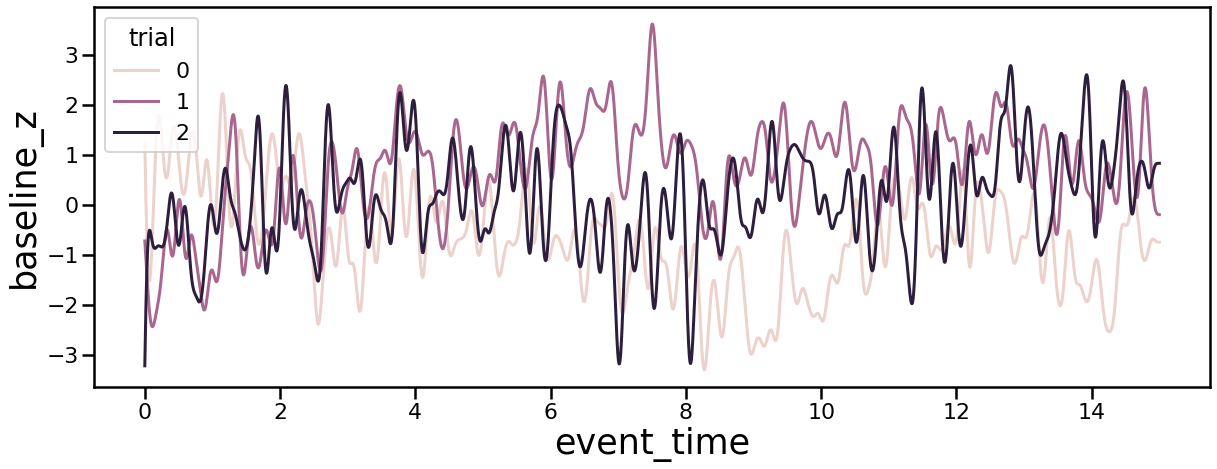

(45000, 34)


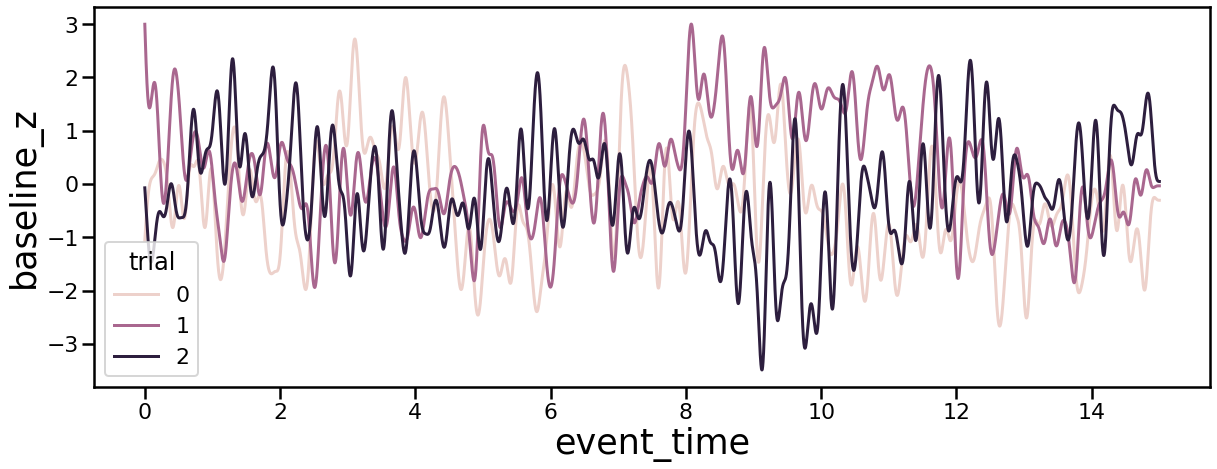

(45000, 34)


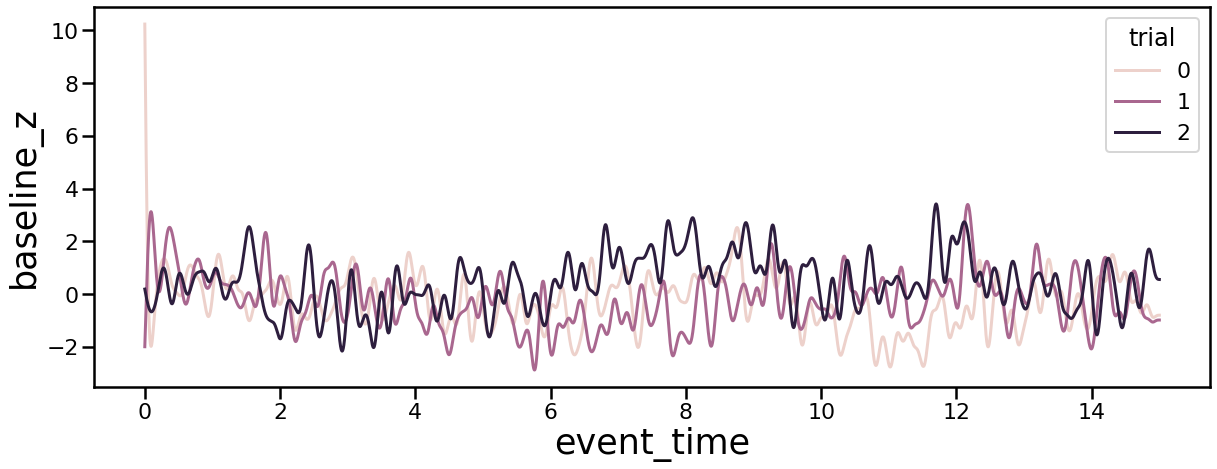

2192
(45000, 34)


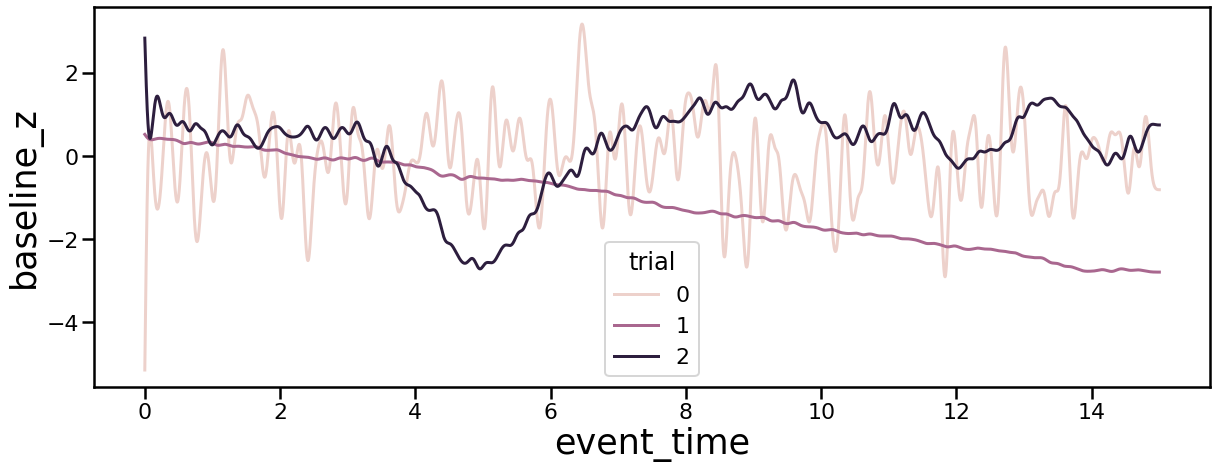

(45000, 34)


(45000, 34)


2164
(45000, 34)


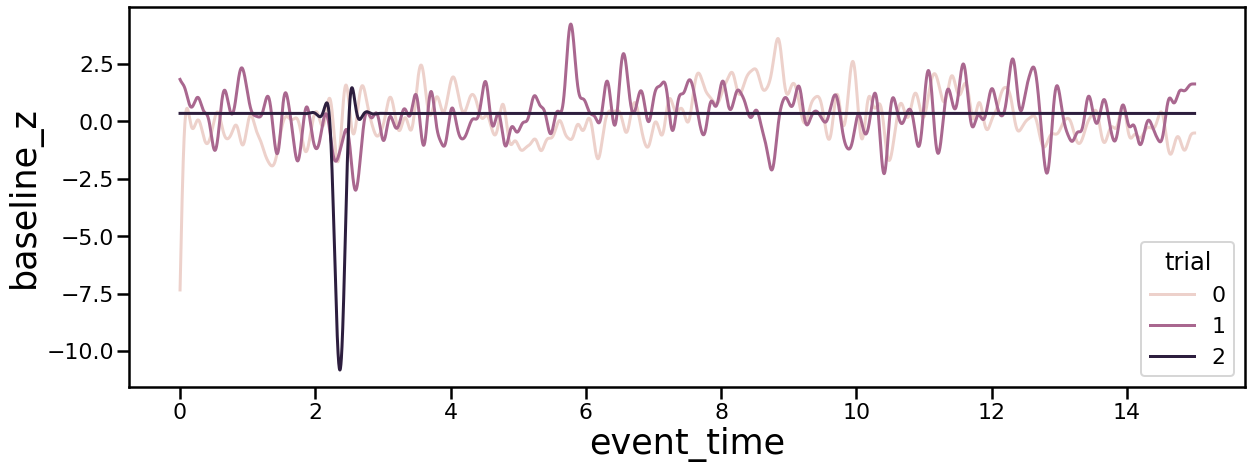

(45000, 34)


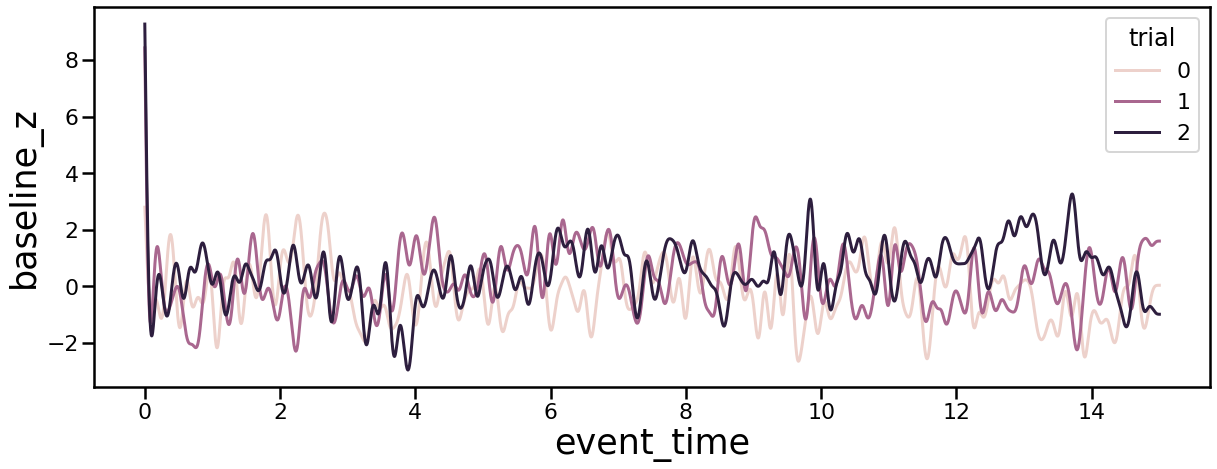

(45000, 34)


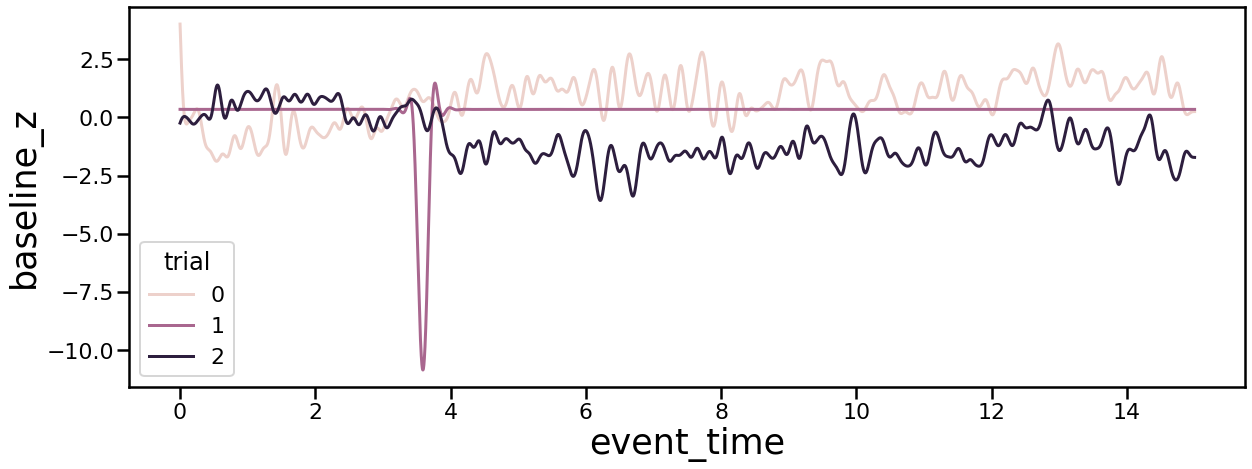

2165
(45000, 34)


(45000, 34)


(45000, 34)


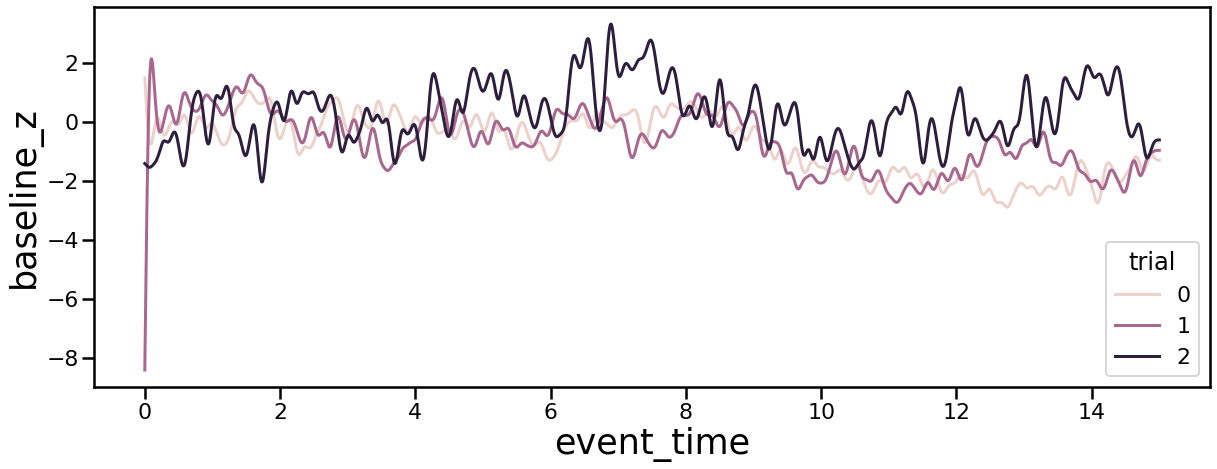

2166
(45000, 34)


(45000, 34)


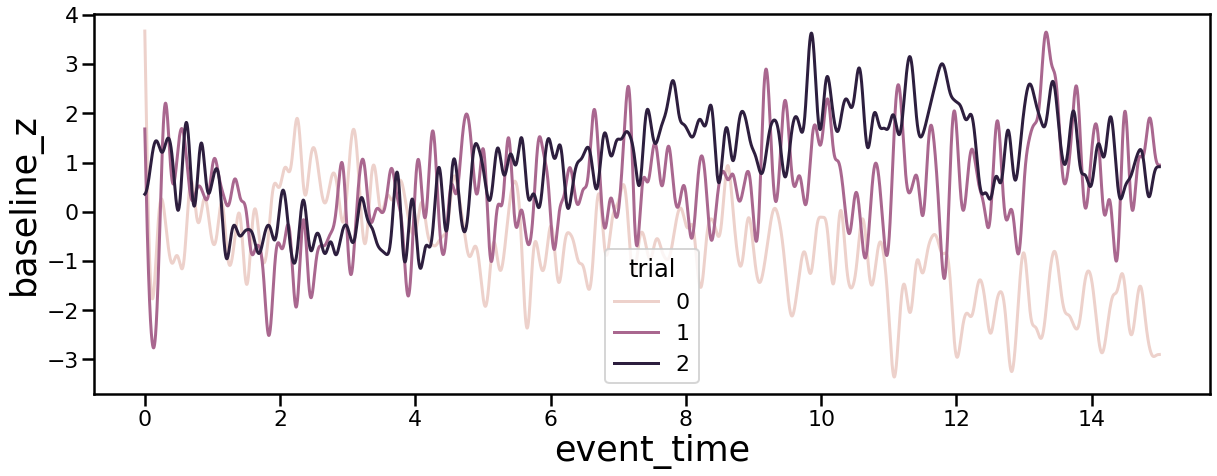

(45000, 34)


2168
(45000, 34)


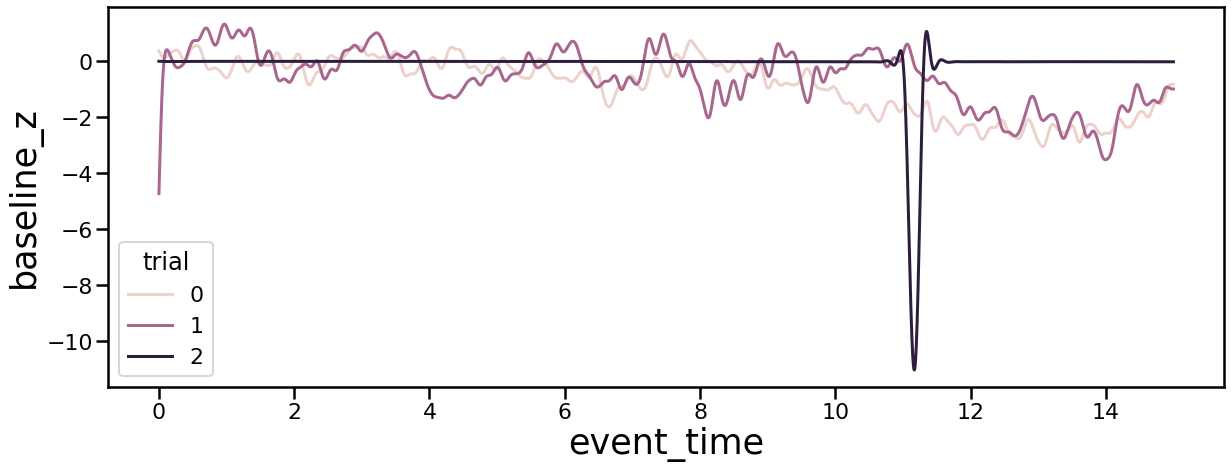

(45000, 34)


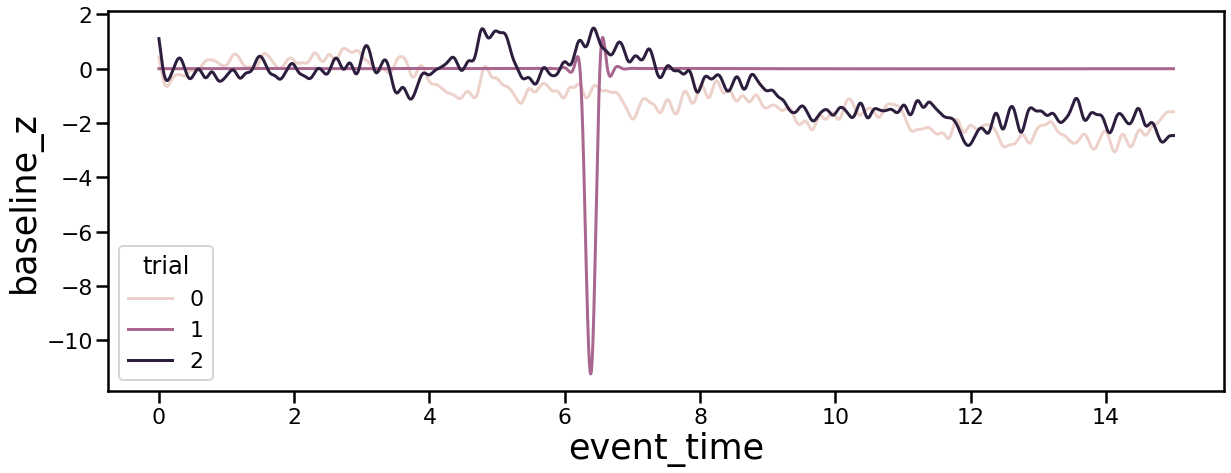

(45000, 34)


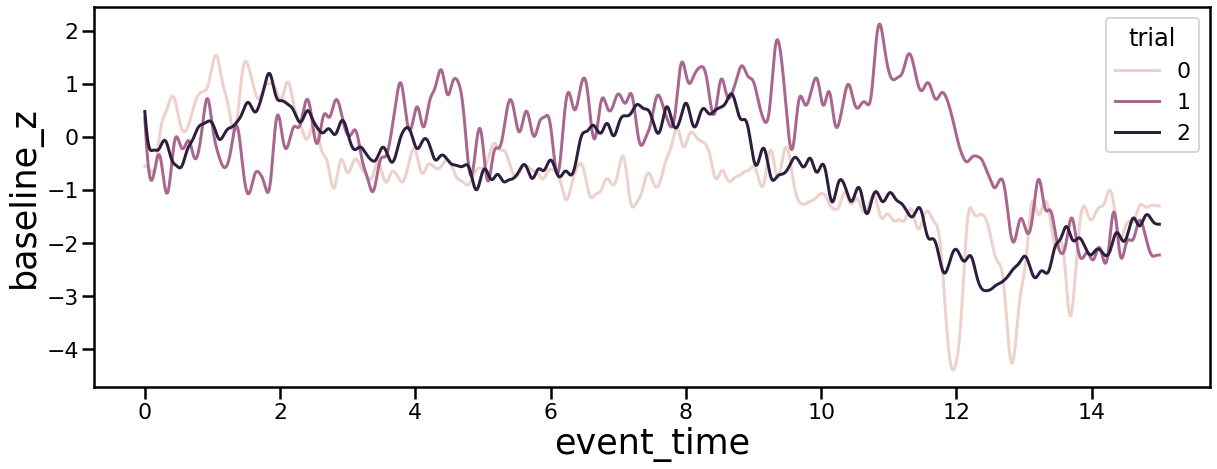

2202
(45000, 34)


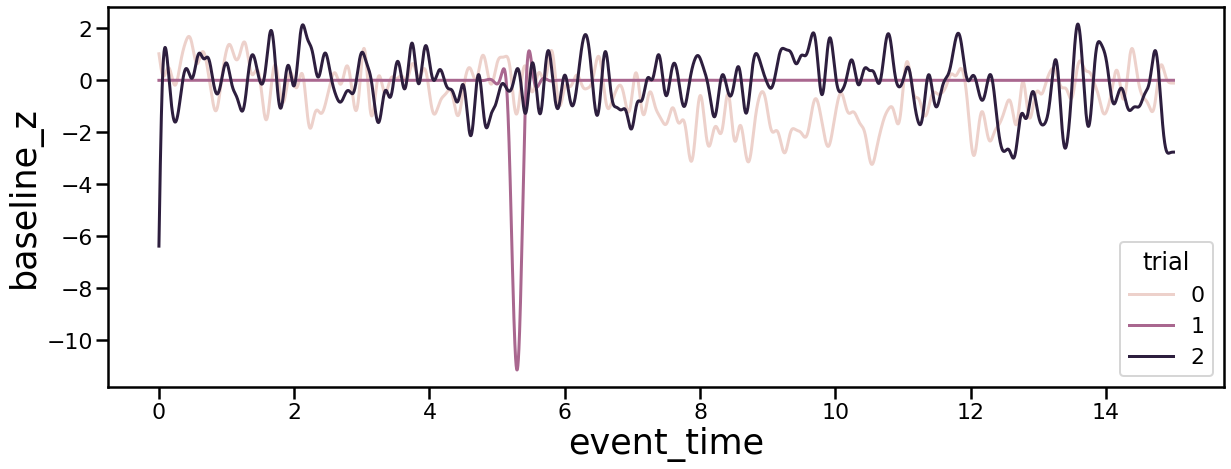

(45000, 34)


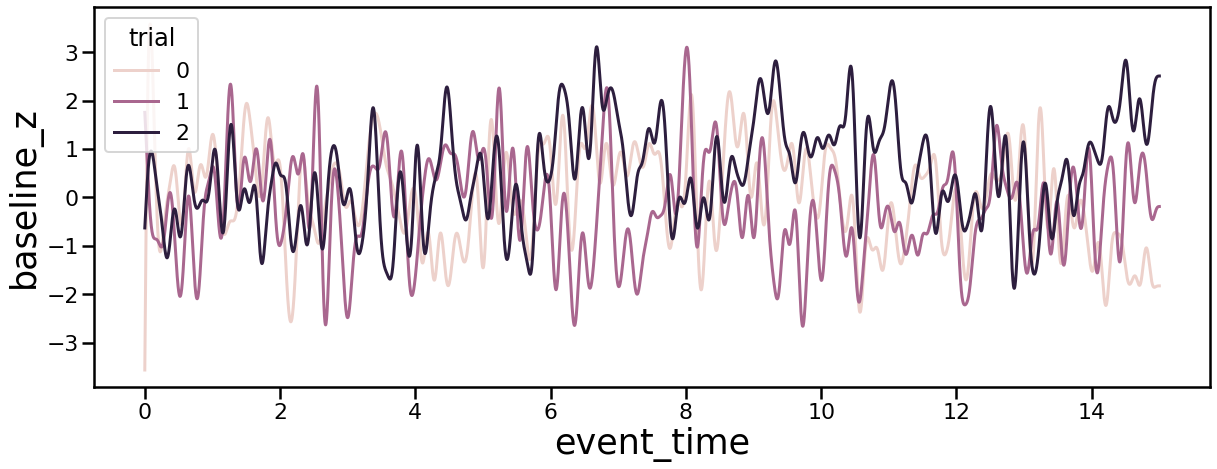

(45000, 34)


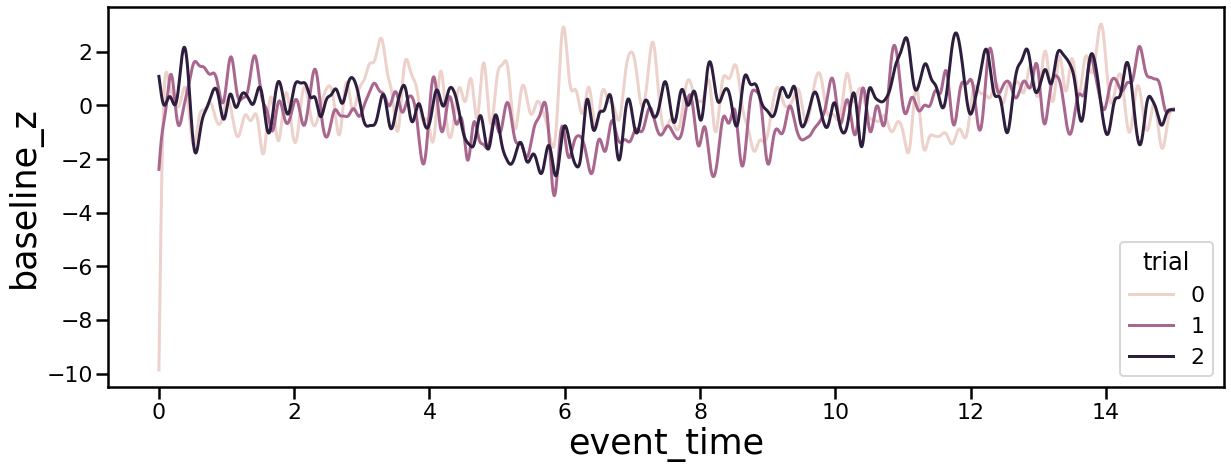

In [15]:
for animal in PE_df['animal'].unique():
  print(animal)
  data_animal = PE_df[PE_df['animal']==animal]

  for event in data_animal['event'].unique():
    print(data_animal[data_animal['event']==event].shape)

    plt.figure(figsize=(20,7))
    sns.lineplot(x='event_time', y='baseline_z', data=data_animal[data_animal['event']==event], ci=None, n_boot=1, markers=True, hue='trial')
    plt.show()